### Phase 4: Build XGboost machine learning model for traffic flow forecast

In [1]:
# measure execution time
%load_ext autotime

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

time: 2.72 s (started: 2023-07-11 23:26:33 +03:00)


### Load the time series traffic flow dataset

In [2]:
# read dataset
time_series = pd.read_csv('C:/Users/SK/Desktop/Πτυχιακή\Files/time_series.txt')

# this list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

# generate the columns of the dataset
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-18 00:00:00'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))
    
    if (columns[i]>=pd.to_datetime('2008-05-24 23:59:59.000130')):
        break
    
    i+=1

# delete the last timestamp
columns.pop()

# assign new column names to our dataframe
time_series.columns = columns


time: 219 ms (started: 2023-07-11 23:26:36 +03:00)


### Transform the time series dataset

In [3]:
# reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = time_series.iloc[:,2:].columns
time_series = time_series.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
time_series['Time Column'] = pd.to_datetime(time_series['Time Column'])

# sort rows by Path and Time
time_series.sort_values(by=['Path','Time Column'],inplace=True)

time: 546 ms (started: 2023-07-11 23:26:36 +03:00)


In [4]:
# convert path column from categorical to numerical
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
label_encoder = LabelEncoder()

# fit label encoder on the 'Path' column
time_series['Path'] = label_encoder.fit_transform(time_series['Path'])

# sort the data based in Path column
time_series = time_series.sort_values(by=['Path','Time Column'])

# print data
time_series.head()

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
593,97,297,0,8,2008-05-18 00:00:00,4
1593,97,297,0,8,2008-05-18 00:30:00,4
2593,97,297,0,8,2008-05-18 01:00:00,4
3593,97,297,0,8,2008-05-18 01:30:00,2
4593,97,297,0,8,2008-05-18 02:00:00,9


time: 2.45 s (started: 2023-07-11 23:26:36 +03:00)


### Weather data
In the weather dataset of San Francisco area, there are many columns that are useless for our research. We just drop them and preprocess the dataset.

In [5]:
# read weather data
weather_data = pd.read_csv('C:/Users/SK/desktop/Πτυχιακή/weather_data.csv',sep=',')

# drop unecessary columns. 
# dropped columns can either have NaN values, or not be associated with traffic flow.
weather_data = weather_data.drop(['name','feelslike','dew','precip','precipprob','preciptype',
                                  'snow','snowdepth','windgust','winddir','cloudcover',
                                  'solarradiation','solarenergy','uvindex','severerisk','stations','icon'],axis=1)

time: 15 ms (started: 2023-07-11 23:26:39 +03:00)


There is one column that contains categorical vales. Use one-hot encoding to represent them as numerical vectors.

In [6]:
# view the values of "conditions" column
weather_data['conditions'].value_counts()

Partially cloudy    435
Clear               166
Overcast            142
Rain, Overcast        1
Name: conditions, dtype: int64

time: 16 ms (started: 2023-07-11 23:26:39 +03:00)


In [7]:
# change the only 'Rain, Overcast' value to 'Overcast'
weather_data.loc[weather_data['conditions'] == 'Rain, Overcast', 'conditions'] = 'Overcast'

time: 15 ms (started: 2023-07-11 23:26:39 +03:00)


In [8]:
# view again the values of "conditions" column
weather_data['conditions'].value_counts()

Partially cloudy    435
Clear               166
Overcast            143
Name: conditions, dtype: int64

time: 16 ms (started: 2023-07-11 23:26:39 +03:00)


In [9]:
# one-hot encode the  "conditions" column
conditions = pd.get_dummies(weather_data['conditions'], prefix='conditions')
weather_data.drop('conditions',axis=1,inplace=True)

# concatenate the one-hot encoded columns to the original DataFrame
weather_data = pd.concat([weather_data, conditions], axis=1)

time: 0 ns (started: 2023-07-11 23:26:39 +03:00)


Now, there are not categorical values.

In [10]:
# view for null values
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     744 non-null    object 
 1   temp                         744 non-null    float64
 2   humidity                     744 non-null    float64
 3   windspeed                    744 non-null    float64
 4   sealevelpressure             744 non-null    float64
 5   visibility                   744 non-null    float64
 6   conditions_Clear             744 non-null    uint8  
 7   conditions_Overcast          744 non-null    uint8  
 8   conditions_Partially cloudy  744 non-null    uint8  
dtypes: float64(5), object(1), uint8(3)
memory usage: 37.2+ KB
time: 31 ms (started: 2023-07-11 23:26:39 +03:00)


There are not null values in the weather dataset too!

In [11]:
# covnert datetime column to appropriate format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# drop rows that are not in within the interval [2008-05-18,2008-05-24]
start_date = pd.to_datetime('2008-05-18')
end_date = pd.to_datetime('2008-05-25')

weather_data = weather_data[(weather_data['datetime'] >= start_date) & (weather_data['datetime'] <= end_date)].reset_index(drop=True)

time: 16 ms (started: 2023-07-11 23:26:39 +03:00)


### Connect the two dataframes to one
Use time information to correctly connect the data together.

In [12]:
# connect two dataframes, time-series traffic flow and weather data
time_series.set_index('Time Column', inplace=True)
weather_data.set_index('datetime', inplace=True)

# resample the 'weather_data' dataset to 15-minute intervals and forward-fill the missing values
weather_data = weather_data.resample('5T').ffill()

# merge the time_series and weather_data_resampled datasets based on their indexes
time_series_weather = time_series.merge(weather_data, left_index=True, right_index=True)

time: 141 ms (started: 2023-07-11 23:26:39 +03:00)


### Visualise the Traffic Flow in every path of the dataset
Use the sum of traffic flow of every path at each timestep to generate a total overview about the data

In [13]:
# group by timestamp (index) and calculate the sum of the traffic flow
grouped_df = time_series_weather['Traffic Flow'].groupby(time_series_weather.index).sum()

time: 31 ms (started: 2023-07-11 23:26:39 +03:00)


In [14]:
# add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

time: 0 ns (started: 2023-07-11 23:26:39 +03:00)


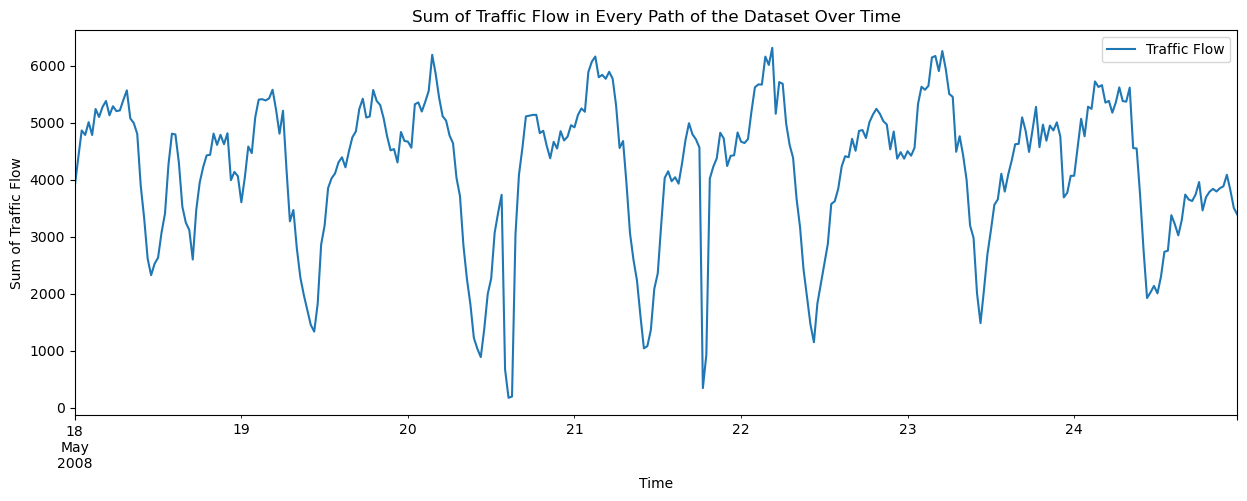

time: 672 ms (started: 2023-07-11 23:26:39 +03:00)


In [15]:
# create a plot to view the results
grouped_df.plot(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Sum of Traffic Flow')
plt.title('Sum of Traffic Flow in Every Path of the Dataset Over Time')
plt.show()

### Feature Creation From Time Information
We define some features based on time series timestamps.
- Day, dayfweek, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval and 6_hour-interval to describe, in which interval of the day (3-hour or 6-hour) we are.

In [16]:
time_series_weather = time_series_weather.reset_index()
time_series_weather.rename(columns={'index': 'Time Column'}, inplace=True)

time: 31 ms (started: 2023-07-11 23:26:40 +03:00)


In [17]:
# extract timestamp information to different columns
time_series_weather['hour'] = time_series_weather['Time Column'].dt.hour
time_series_weather['dayofweek'] = time_series_weather['Time Column'].dt.dayofweek
time_series_weather['day'] = time_series_weather['Time Column'].dt.day
time_series_weather['minute'] = time_series_weather['Time Column'].dt.minute

# circular Encoding for cyclic time features
time_series_weather['hour_sin'] = np.sin(2 * np.pi * time_series_weather['hour'] / 24)
time_series_weather['hour_cos'] = np.cos(2 * np.pi * time_series_weather['hour'] / 24)

time_series_weather['day_of_week_sin'] = np.sin(2 * np.pi * time_series_weather['dayofweek'] / 7)
time_series_weather['day_of_week_cos'] = np.cos(2 * np.pi * time_series_weather['dayofweek'] / 7)

# Convert to cosine and sine values
time_series_weather['day_sin'] = np.sin(2 * np.pi * time_series_weather['day'] / 31)
time_series_weather['day_cos'] = np.cos(2 * np.pi * time_series_weather['day'] / 31)

time_series_weather['minute_sin'] = np.sin(2 * np.pi * time_series_weather['minute'] / 60)
time_series_weather['minute_cos'] = np.cos(2 * np.pi * time_series_weather['minute'] / 60)

time: 282 ms (started: 2023-07-11 23:26:40 +03:00)


In [18]:
# define a custom function to determine the three-hour interval
def get_3hour_interval(hour):
    if hour in [1, 2, 3]:
        return 1
    elif hour in [4, 5, 6]:
        return 2
    elif hour in [7, 8, 9]:
        return 3
    elif hour in [10, 11, 12]:
        return 4
    elif hour in [13, 14, 15]:
        return 5
    elif hour in [16, 17, 18]:
        return 6
    elif hour in [19, 20, 21]:
        return 7
    elif hour in [22, 23, 0]:
        return 8
    else:
        return None   

time: 0 ns (started: 2023-07-11 23:26:40 +03:00)


In [19]:
# apply the custom function to create the '3hour_interval' column
time_series_weather['3hour_interval'] = time_series_weather['hour'].apply(get_3hour_interval)

time: 281 ms (started: 2023-07-11 23:26:40 +03:00)


In [20]:
# print dataset
time_series_weather

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,humidity,windspeed,sealevelpressure,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,2008-05-18 00:00:00,97,297,0,8,4,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,8
1,2008-05-18 00:00:00,2,83,1,3,4,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,8
2,2008-05-18 00:00:00,247,370,2,10,7,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,8
3,2008-05-18 00:00:00,327,78,3,2,5,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,8
4,2008-05-18 00:00:00,363,56,4,11,0,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335995,2008-05-24 23:30:00,403,113,995,6,2,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
335996,2008-05-24 23:30:00,477,44,996,9,0,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
335997,2008-05-24 23:30:00,135,125,997,2,3,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
335998,2008-05-24 23:30:00,192,164,998,12,0,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8


time: 203 ms (started: 2023-07-11 23:26:41 +03:00)


### Train - Test split
Split the data into two datasets train and test.
The time inteval of all observations in this dataset are within [18-05-2008, 24-05-2008].
- Train dataset contains all the data for each path till 2008-05-23 inclusive.
- The rest of the data (the most resent ones) are in the test dataset

In [21]:
# sort the time series data
time_series_weather.sort_values(by=['Path','Time Column'], inplace=True)

time: 234 ms (started: 2023-07-11 23:26:41 +03:00)


In [22]:
# define train data
train = time_series_weather.loc[time_series_weather['Time Column'] < '2008-05-24']

# define test data
test = time_series_weather.loc[time_series_weather['Time Column'] >= '2008-05-24']

# print the results
print("Train set shape: ",train.shape)
print("Test set shape: ",test.shape)

Train set shape:  (288000, 27)
Test set shape:  (48000, 27)
time: 141 ms (started: 2023-07-11 23:26:41 +03:00)


### Find the best lookback timesteps for our XGBoost model

#### Step 0: Create empty dataframe to store the scores per lookback timesteps

In [23]:
# find best lookback timesteps to perform analysis. Save those scores in a separate dataframe
lookback_scores = pd.DataFrame(columns=['#Timesteps','XGBoost Score'])
lookback_scores['#Timesteps'] = 0
lookback_scores['XGBoost Score'] = 0

time: 0 ns (started: 2023-07-11 23:26:43 +03:00)


#### Step 1: Create function that converts the data into a supervised problem
Consider for each path n_in timesteps of traffic flow in the past, in order to predict the n_out traffic flow timesteps in the future.

In [24]:
from pandas import DataFrame
from pandas import concat

# create functio for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Traffic Flow %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Traffic Flow %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Traffic Flow %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    return agg

time: 15 ms (started: 2023-07-11 23:26:44 +03:00)


In [25]:
"""
Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
Then, concatenate the rest of the culumns. 
"""
def generate_X_y_pairs(data,n_in=1,n_out=1):
    new_data = pd.DataFrame()
    for item in data['Path'].unique():
        
        # call function only for traffic flow columns
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)
        
        # the rest of the columns are concatenated as they were
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, time_series_weather[time_series_weather['Path'] == item]], axis=1)
        
        new_data = pd.concat([new_data,supervised_traffic_flow])

    new_data.dropna(inplace=True)
    return new_data

time: 15 ms (started: 2023-07-11 23:26:45 +03:00)


#### Step 2: Create a loop. In each loop, we are doing the following:
- 0. Convert train and test sets into supervised problem with lookback timesteps.
- 1. Define features and labels.
- 2. Train the XGboost model with defult parameters
- 3. Predict on the test set
- 4. Save RMSE in a dataframe

In [26]:
# import libraries
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

time: 719 ms (started: 2023-07-11 23:26:47 +03:00)


In [27]:
# use a sample of trainning and testing set to find the optimum lookback period
train_sample = train.head(50000)
test_sample = test.head(5000)

time: 0 ns (started: 2023-07-11 23:26:48 +03:00)


In [28]:
for lookback in [2,3,4,5,6,7,8]: # different lookback sizes
    
    # convert train and test data to supervised
    train_s = generate_X_y_pairs(train_sample,lookback)
    test_s = generate_X_y_pairs(test_sample,lookback)
    
    print("Lookback = "+str(lookback)+" - To supervised: Completed!")

    # add rolling mean information
    train_s['rolling_mean'] = 0
    test_s['rolling_mean'] = 0
    
    train_s['rolling_mean'] = train_s.iloc[:,0:lookback].mean(axis=1)
    test_s['rolling_mean'] = test_s.iloc[:,0:lookback].mean(axis=1)
    
    # define features
    features_s = train_s.drop(['Time Column','Traffic Flow 1(t)'],axis=1).columns
    
    # define label
    labels_s = ['Traffic Flow 1(t)']
    
    # create X_train and y_train datasets
    X_train_s = train_s[features_s]
    y_train_s = train_s[labels_s]
    
    # create X_test and y_test datasets
    X_test_s = test_s[features_s]
    y_test_s = test_s[labels_s]
    
    print("Lookback = "+str(lookback)+" - Train and Test sets: Completed!")

    # define XGBoost regression model
    reg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000,early_stopping_rounds = 5)
    
    # train the XGBoost model with feature weights, use validation set on test data)
    reg.fit(X_train_s, y_train_s, eval_set=[(X_train_s, y_train_s), (X_test_s,y_test_s)],verbose=False)
    
    print("Lookback = "+str(lookback)+" - Trainning: Completed!")
    
    # make predictions
    y_pred_s = reg.predict(X_test_s)
    
    # calculate RMSE score
    rmse = mean_squared_error(y_test_s, y_pred_s, squared=False)
   
    # create a new row as a dictionary
    new_row = {'#Timesteps': lookback, 'XGBoost Score': rmse}

    # append the new row to the DataFrame
    lookback_scores = lookback_scores.append(new_row, ignore_index=True)
    
    print("Lookback = "+str(lookback)+" - Saved Results: Completed!")

Lookback = 2 - To supervised: Completed!
Lookback = 2 - Train and Test sets: Completed!
Lookback = 2 - Trainning: Completed!
Lookback = 2 - Saved Results: Completed!
Lookback = 3 - To supervised: Completed!
Lookback = 3 - Train and Test sets: Completed!
Lookback = 3 - Trainning: Completed!
Lookback = 3 - Saved Results: Completed!
Lookback = 4 - To supervised: Completed!
Lookback = 4 - Train and Test sets: Completed!
Lookback = 4 - Trainning: Completed!
Lookback = 4 - Saved Results: Completed!
Lookback = 5 - To supervised: Completed!
Lookback = 5 - Train and Test sets: Completed!
Lookback = 5 - Trainning: Completed!
Lookback = 5 - Saved Results: Completed!
Lookback = 6 - To supervised: Completed!
Lookback = 6 - Train and Test sets: Completed!
Lookback = 6 - Trainning: Completed!
Lookback = 6 - Saved Results: Completed!
Lookback = 7 - To supervised: Completed!
Lookback = 7 - Train and Test sets: Completed!
Lookback = 7 - Trainning: Completed!
Lookback = 7 - Saved Results: Completed!
Look

####  Step 3: Print RMSE scores over lookback timesteps into a graph

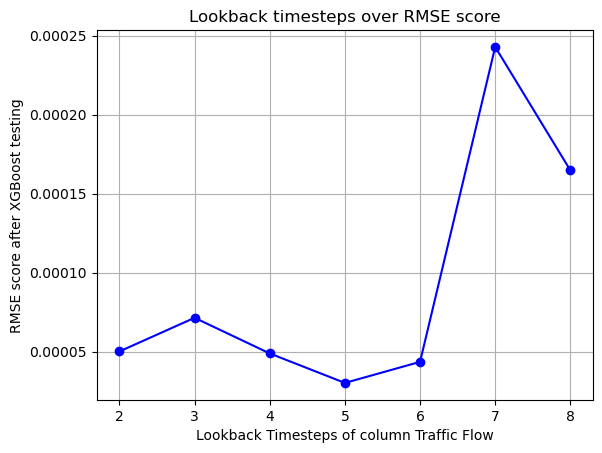

time: 313 ms (started: 2023-07-11 23:27:50 +03:00)


In [29]:
# plot the data
plt.plot(lookback_scores['#Timesteps'], lookback_scores['XGBoost Score'], linestyle='-', marker='o', color='b')

# set plot title and axis labels
plt.title('Lookback timesteps over RMSE score')
plt.xlabel('Lookback Timesteps of column Traffic Flow')
plt.ylabel('RMSE score after XGBoost testing')

# add gridlines
plt.grid(True)

# show the plot
plt.show()

In [30]:
# find the timesteps corresponding to the minimum RMSE score
optimum_lookback = int(lookback_scores['#Timesteps'].loc[lookback_scores['XGBoost Score'].idxmin()])

time: 0 ns (started: 2023-07-11 23:27:50 +03:00)


### Perform Grid Search CV to find the optimum parameters for the XGBoost model

#### Step 0: Split train and test into supervised problem, based on optimum lookback timesteps that found above.

In [31]:
# convert train and test data to supervised
train = generate_X_y_pairs(train,optimum_lookback)
test = generate_X_y_pairs(test,optimum_lookback)

time: 1min 5s (started: 2023-07-11 23:27:50 +03:00)


#### Step 1: Extract features about trend of time series
- Rolling mean is a statistical measure that si commonly used in time series analysis and data smoothing. It is calculated over a sliding window or a rolling window, where the window size determines the number of consecutive data points included in the calculation.The rolling mean (or moving average) calculates the average value of a time series within a specific window. It smooths out short-term fluctuations and provides a smoothed representation of the data. The rolling mean at each time point is the average of the values within the window centered around that time point.

In [32]:
# add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

train['rolling_var'] = 0
test['rolling_var'] = 0

train['rolling_median'] = 0
test['rolling_median'] = 0

train['rolling_std'] = 0
test['rolling_std'] = 0

train['rolling_mean'] = train.iloc[:,0:optimum_lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

# Calculate rolling median
train['rolling_median'] = train.iloc[:, 0:optimum_lookback].median(axis=1)
test['rolling_median'] = test.iloc[:, 0:optimum_lookback].median(axis=1)

# Calculate rolling standard deviation
train['rolling_std'] = train.iloc[:, 0:optimum_lookback].std(axis=1)
test['rolling_std'] = test.iloc[:, 0:optimum_lookback].std(axis=1)

time: 125 ms (started: 2023-07-11 23:28:56 +03:00)


####  Step 2: Define labels and features
- Features will help the XGboost algorithm to predict the putput value, the label. We will use all the traffic flow information at previous timesteps (t-n,t-n+1...,t-2,t-1), as well as the rest of the features (time and trend information) as features.
- Label will be out target value, the Traffic Flow at timestep t.

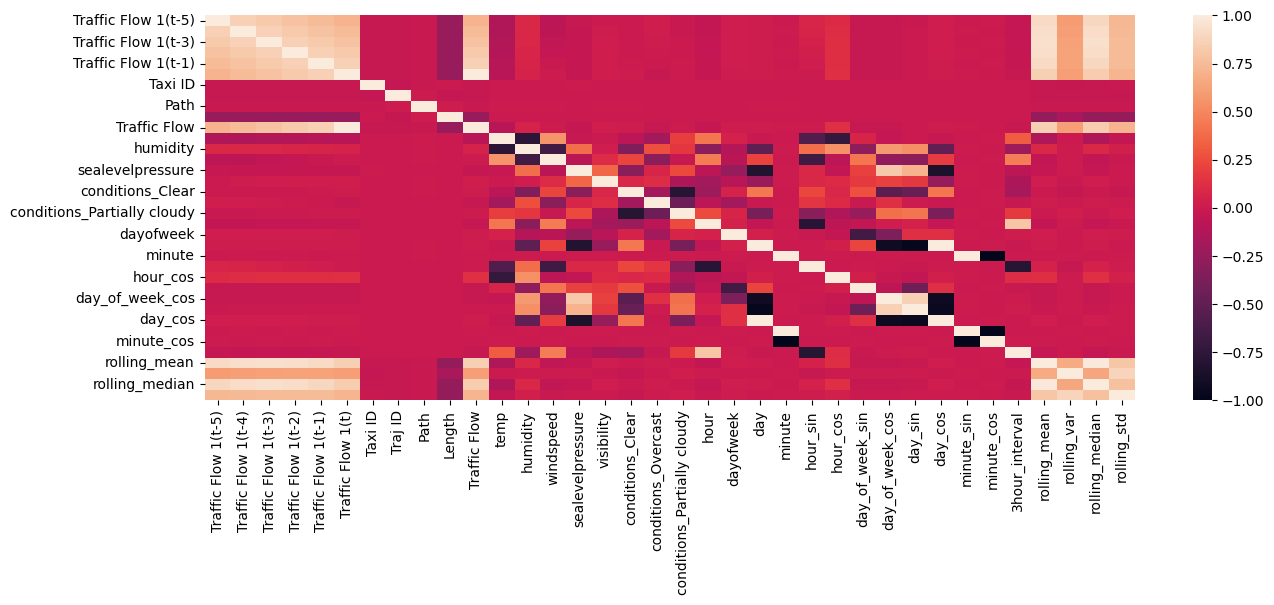

time: 2.78 s (started: 2023-07-11 23:28:56 +03:00)


In [33]:
# view correlations among the features and don't use higly correlated ones
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.heatmap(train.corr())
plt.show()

In [34]:
# define features
features = train.drop(['Time Column','Traffic Flow','Traffic Flow 1(t)','hour', 'dayofweek', 'day', 'minute'],axis=1).columns

# define labels
labels = ['Traffic Flow 1(t)']

# create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

time: 171 ms (started: 2023-07-11 23:28:59 +03:00)


In [35]:
# show shape information about X and y training and testing sets
print("Shape of X_train is: ",X_train.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (283000, 30)
Shape of y_train is:  (283000, 1)
Shape of X_test is:  (43000, 30)
Shape of y_test is:  (43000, 1)
time: 0 ns (started: 2023-07-11 23:28:59 +03:00)


#### Step 3: Apply GridSearchCV
Use a 5-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [36]:
from sklearn.model_selection import GridSearchCV

time: 0 ns (started: 2023-07-11 23:28:59 +03:00)


In [ ]:
# tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [3000],
    "learning_rate": [0.1,0.01],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,1,2],
    "alpha": [0,0.1]
}

# define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(), 
                        xgb_params,cv=3,
                        verbose=1,
                        scoring= "neg_mean_squared_error")

# train on train data using 5 fold CV
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

In [37]:
# create dataframe to store actual values and predicted ones
total_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
total_predictions['Actual'] = y_test['Traffic Flow 1(t)'].values
total_predictions['Path'] = X_test['Path'].values

time: 32 ms (started: 2023-07-11 23:28:59 +03:00)


### Train an XGboost model
We will fit all the data in this model using the optimum parameters that found above. The optimum parameters for this dataset are: 
- n_estimators = 3000
- learning_rate = 0.1
- max_depth = 6
- alpha = 0.5
- gamma = 0.3

#### Step 0: Create XGBoost model and train it

In [38]:
# define XGBoost regressor, use also gamma and alpha values for regularization
reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=3000,
    early_stopping_rounds=5,
    max_depth=6 ,
    learning_rate=0.1,
    gamma=0.3,
    alpha=0.5    
)

# train the XGBoost model with feature weights, use validation set on test data)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test,y_test)], 
        verbose=True)

[0]	validation_0-rmse:6.80839	validation_1-rmse:6.07890
[1]	validation_0-rmse:6.27167	validation_1-rmse:5.60121
[2]	validation_0-rmse:5.79931	validation_1-rmse:5.18563
[3]	validation_0-rmse:5.38412	validation_1-rmse:4.82004
[4]	validation_0-rmse:5.02224	validation_1-rmse:4.50283
[5]	validation_0-rmse:4.70700	validation_1-rmse:4.22994
[6]	validation_0-rmse:4.43280	validation_1-rmse:3.99417
[7]	validation_0-rmse:4.19669	validation_1-rmse:3.79293
[8]	validation_0-rmse:3.99323	validation_1-rmse:3.62674
[9]	validation_0-rmse:3.81998	validation_1-rmse:3.48213
[10]	validation_0-rmse:3.66989	validation_1-rmse:3.35741
[11]	validation_0-rmse:3.54264	validation_1-rmse:3.25580
[12]	validation_0-rmse:3.43605	validation_1-rmse:3.17053
[13]	validation_0-rmse:3.34375	validation_1-rmse:3.10311
[14]	validation_0-rmse:3.26657	validation_1-rmse:3.04765
[15]	validation_0-rmse:3.20065	validation_1-rmse:2.99775
[16]	validation_0-rmse:3.14457	validation_1-rmse:2.95762
[17]	validation_0-rmse:3.09797	validation

XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

time: 29.5 s (started: 2023-07-11 23:28:59 +03:00)


##### Feature Importance
Show how our model used the feautres, in order to perform splits. 

<Figure size 1500x500 with 0 Axes>

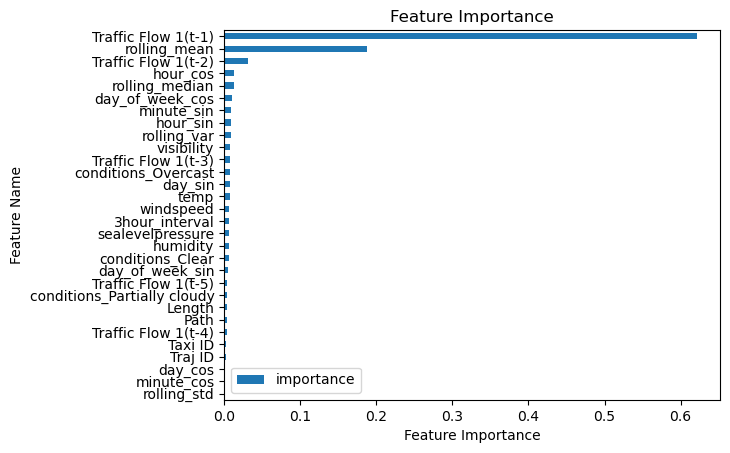

time: 594 ms (started: 2023-07-11 23:29:29 +03:00)


In [39]:
# Show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

##### Plot train and validation errors in the same graph

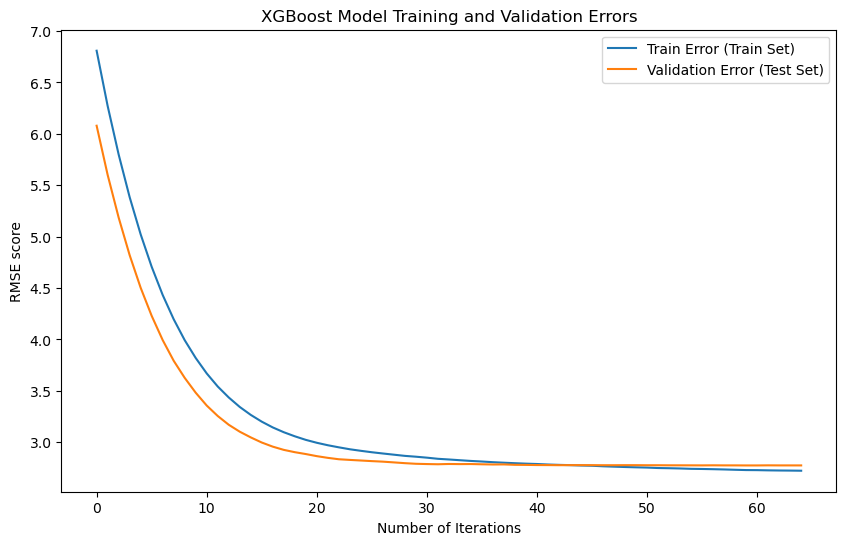

time: 344 ms (started: 2023-07-11 23:29:29 +03:00)


In [40]:
# acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Error (Train Set)')
plt.plot(validation_errors, label='Validation Error (Test Set)')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE score')
plt.title('XGBoost Model Training and Validation Errors')
plt.legend()
plt.show()

##### Make predictions on the test set

In [41]:
y_pred_xgboost = reg.predict(X_test)

time: 109 ms (started: 2023-07-11 23:29:30 +03:00)


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the MAE
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.7307811113885323
RMSE score: 2.7748847385970605
time: 15 ms (started: 2023-07-11 23:29:30 +03:00)


##### Show example of how well the model learned the trainning data

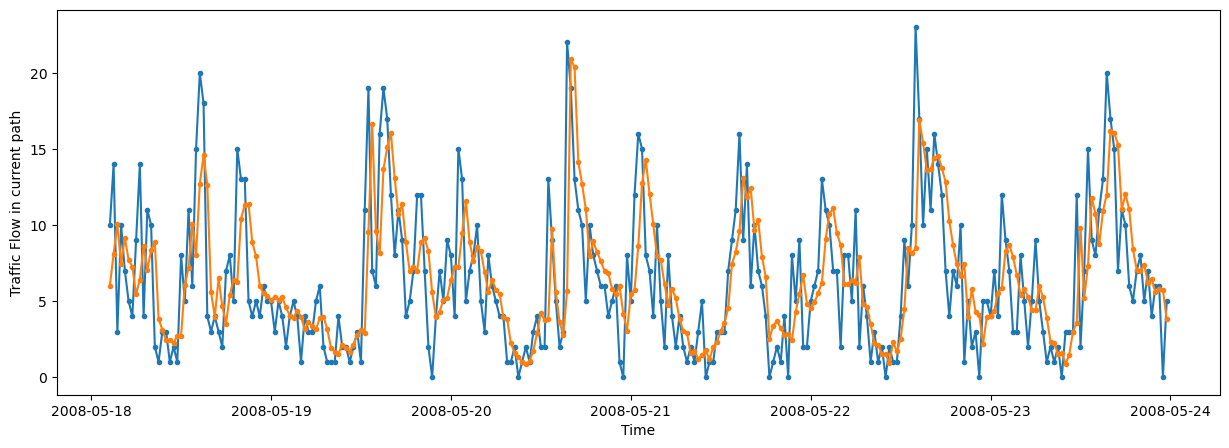

time: 937 ms (started: 2023-07-11 23:29:30 +03:00)


In [43]:
# predict on the trainning set
y_pred_train = reg.predict(X_train)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train)
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.show()

##### Show an example of actual values vs predicted

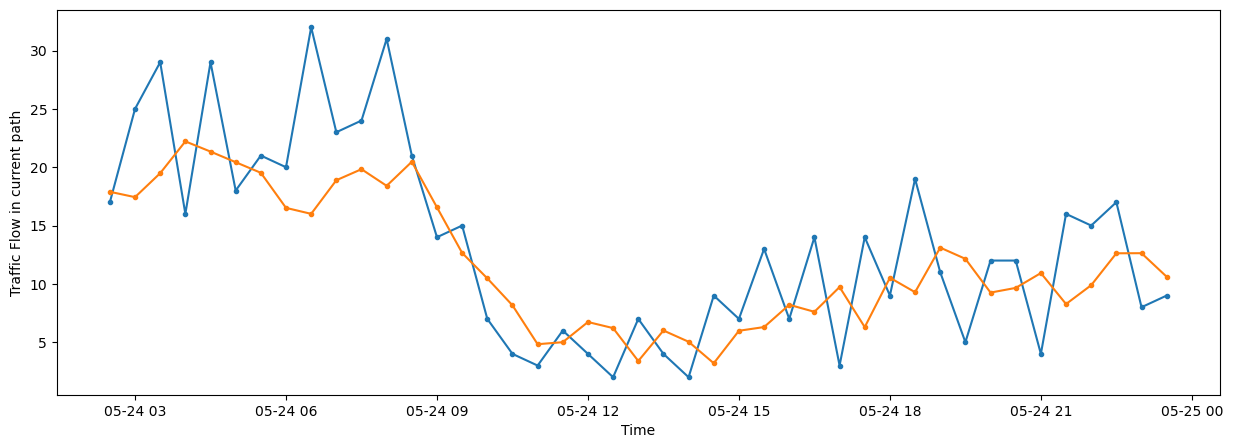

time: 406 ms (started: 2023-07-11 23:29:31 +03:00)


In [44]:
test_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
test_predictions.insert(0,'Test Actual',y_test['Traffic Flow 1(t)'].values)
test_predictions.insert(1,'Test Predicted',y_pred_xgboost)
test_predictions.insert(2,'Path',X_test['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(test_predictions[test_predictions['Path']==43][['Test Actual','Test Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.show()

### Train LSTM for time series forecasting

#### Step 0: Create the train and test sets as before, then scale them
Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them to the LSTM RNN.

In [45]:
from sklearn.preprocessing import MinMaxScaler

time: 0 ns (started: 2023-07-11 23:29:31 +03:00)


In [46]:
# scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

time: 219 ms (started: 2023-07-11 23:29:31 +03:00)


In [47]:
# create train set
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])
    
for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])
    
trainX, trainY = np.array(trainX), np.array(trainY)

time: 1.02 s (started: 2023-07-11 23:29:31 +03:00)


In [48]:
# create test set
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])
    
for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])
    
testX, testY = np.array(testX), np.array(testY)

time: 141 ms (started: 2023-07-11 23:29:32 +03:00)


In [49]:
# print shapes of the created tests
trainX.shape, trainY.shape, testX.shape, testY.shape

((283000, 1, 30), (283000, 1, 1), (43000, 1, 30), (43000, 1, 1))

time: 15 ms (started: 2023-07-11 23:29:33 +03:00)


#### Step 2: Use the LSTM model for forecasting

##### Import libraries and define the LSTM structure

In [50]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

time: 16.3 s (started: 2023-07-11 23:29:33 +03:00)


In [51]:
# Define model
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Final LSTM layer without return_sequences=True
model.add(LSTM(6, activation='relu'))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))
model.add(Dense(trainY.shape[1]))  # Output layer


# Add early stopping
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

time: 1.11 s (started: 2023-07-11 23:29:49 +03:00)


##### Compile the model

In [52]:
# compile model
model.compile(optimizer='adam', loss='mse')

time: 16 ms (started: 2023-07-11 23:29:50 +03:00)


##### Train the model

In [53]:
# fit model on training data
model.fit(trainX, trainY, epochs=50, batch_size=len(trainX)//100,validation_data=(testX,testY), verbose=1, callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 29s 201ms/step - loss: 0.0086 - val_loss: 0.0125
Epoch 2/50
100/100 [==============================] - 19s 192ms/step - loss: 0.0084 - val_loss: 0.0125
Epoch 3/50
100/100 [==============================] - 19s 189ms/step - loss: 0.0084 - val_loss: 0.0126
Epoch 4/50
100/100 [==============================] - 19s 188ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 5/50
100/100 [==============================] - 19s 190ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 6/50
100/100 [==============================] - 19s 188ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 7/50
100/100 [==============================] - 19s 193ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 8/50
100/100 [==============================] - 20s 204ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 9/50
100/100 [==============================] - 20s 202ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 10/50
100/100 [==============================] - 21s 213ms/step - l

time: 5min 9s (started: 2023-07-11 23:29:50 +03:00)


In [54]:
# evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1344/1344 [==============================] - 7s 5ms/step - loss: 0.0037
Test Loss: 0.003678497625514865
time: 6.78 s (started: 2023-07-11 23:35:00 +03:00)


##### Make predictions and store them in dataframe

In [55]:
# predict on test data
y_pred_lstm = model.predict(testX)

1344/1344 [==============================] - 7s 4ms/step
time: 8.14 s (started: 2023-07-11 23:35:07 +03:00)


In [56]:
# calculate the mae of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mean absolute error of LSTM model is: ",mae_lstm)

Mean absolute error of LSTM model is:  3.887966002299212
time: 15 ms (started: 2023-07-11 23:35:15 +03:00)


### Create Random Forest model

In [57]:
from sklearn.ensemble import RandomForestRegressor

time: 1.06 s (started: 2023-07-11 23:35:15 +03:00)


#### Step 0: Find optimum parameters for random forest

In [ ]:
# define the parameter grid for the grid search
param_grid = {
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 8],
}

# create the Random Forest model
rf_model = RandomForestRegressor()

# create the GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error',verbose=1)

# fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print the best parameters and the best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


#### Step 1: Create and train best model

In [ ]:
# get the best model after Grid Search
best_model = grid_search.best_estimator_

#### Step 2: Make predictions

In [ ]:
# make predictions on the test set
y_pred_rf = best_model.predict(X_test)

#### Step 3: Plot the score of the random forest regressor

In [ ]:
# calculate the MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("MAE: ", mae_rf)

# calculate the RMSE
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print("RMSE: ", rmse_rf)

### Train an Encoder-Decoder model

#### Step 0: Initialize and compile the model

In [ ]:
from keras import layers

In [ ]:
BATCH_SIZE = 1
BUFFER_SIZE = 1000 # was 1000

train_univariate = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((testX, testY))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
# Encoder
enco_deco = Sequential()
enco_deco.add(LSTM(100, input_shape=(1, trainX.shape[2]), return_sequences=True))
enco_deco.add(Dropout(0.2))  # Add dropout to the first LSTM layer
enco_deco.add(LSTM(units=50, return_sequences=True))
enco_deco.add(Dropout(0.2))  # Add dropout to the second LSTM layer
enco_deco.add(LSTM(units=15))  

# Feature vector
enco_deco.add(layers.RepeatVector(1))  

# Decoder
enco_deco.add(LSTM(units=100, return_sequences=True))
enco_deco.add(LSTM(units=50, return_sequences=True))
enco_deco.add(TimeDistributed(layers.Dense(units=1)))

In [ ]:
enco_deco.compile(optimizer='adam', loss='mse')

#### Step 1: Train the model and make predictions

In [ ]:
# train the model
history = enco_deco.fit(train_univariate, epochs=50, steps_per_epoch=len(trainX)//100,
                        validation_data=val_univariate, validation_steps=len(testX)//100, verbose=1, callbacks=[early_stopping])

In [ ]:
# make predictions
predicted_enco_deco = enco_deco.predict(testX)
predicted_enco_deco = scaler.inverse_transform(predicted_enco_deco.reshape(-1, 1))

#### Step 2: Evaluate the model

In [ ]:
# Calculate MAE
mae_enco_deco = mean_absolute_error(y_test, predicted_enco_deco)

# Calculate RMSE
rmse_enco_deco = mean_squared_error(y_test, predicted_enco_deco, squared=False)

print("MAE:", mae_enco_deco)
print("RMSE:", rmse_enco_deco)

Plot train loss vs. validation loss

In [ ]:
# Get the loss and validation loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss and validation loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Add predictions of the three models to the same dataframe

In [ ]:
# store predictions of XGBoost model to a dataframe
total_predictions['Predicted XGBoost'] = y_pred_xgboost

In [ ]:
# store predictions of LSTM model to a dataframe
total_predictions['Predicted LSTM'] = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

In [ ]:
# add predictions of random forest
total_predictions['Predicted Random Forest'] = y_pred_rf

In [ ]:
# add predictions of encoder decoder model
total_predictions['Predicted Encoder Decoder Model'] = predicted_enco_deco

In [ ]:
# print predictions with random forest
total_predictions

### Plot examples of actual vs Predicted for each of the models

In [ ]:
# plot results from XGBoost
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted XGBoost'],label='Predicted')
plt.legend()
plt.plot()

In [ ]:
# plot results from LSTM
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted LSTM'],label='Predicted')
plt.legend()
plt.plot()

In [ ]:
# plot results from Random Forest
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted Random Forest'],label='Predicted')
plt.legend()
plt.plot()

In [ ]:
# plot results from Encoder Decoder
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted Encoder Decoder Model'],label='Predicted')
plt.legend()
plt.plot()